# CS224n

## SVD练习

In [1]:
import numpy as np

words = ['I', 'like', 'enjoy', 'deep', 'learning', 'NLP', 'flying', '.']
X = np.array([[0, 2, 1, 0, 0, 0, 0, 0],
              [2, 0, 0, 1, 0, 1, 0, 0],
              [1, 0, 0, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 1],
              [0, 1, 0, 0, 0, 0, 0, 1],
              [0, 0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 1, 1, 1, 0]])

U, s, Vh = np.linalg.svd(X, full_matrices=False)

In [2]:
print('U', U)
print('s', s)
print('Vh', Vh)

U [[-5.24124930e-01 -5.72859145e-01  9.54463014e-02  3.83228493e-01
  -1.76963375e-01 -1.76092183e-01 -4.19185600e-01 -5.57702732e-02]
 [-5.94438071e-01  6.30120664e-01 -1.70207779e-01  3.10038363e-01
   1.84062339e-01 -2.34777849e-01  1.29535474e-01  1.36813128e-01]
 [-2.56274005e-01  2.74017533e-01  1.59810848e-01  3.88578059e-16
  -5.78984617e-01  6.36550929e-01 -9.15933995e-16 -3.05414877e-01]
 [-2.85637408e-01 -2.47912130e-01  3.54610324e-01 -7.31901294e-02
   4.45784489e-01  8.36141432e-02  5.48721075e-01 -4.68012411e-01]
 [-1.93139313e-01  3.38495048e-02 -5.00790405e-01 -4.28462480e-01
   3.47110226e-01  1.55483227e-01 -4.68663749e-01 -4.03576557e-01]
 [-3.05134684e-01 -2.93988990e-01 -2.23433593e-01 -1.91614246e-01
   1.27460940e-01  4.91219408e-01  2.09592800e-01  6.57535375e-01]
 [-1.82489837e-01 -1.61027767e-01 -3.97842428e-01 -3.83228493e-01
  -5.12923221e-01 -4.27574417e-01  4.19185600e-01 -1.18313828e-01]
 [-2.46898426e-01  1.57254762e-01  5.92991677e-01 -6.20076727e-01
 

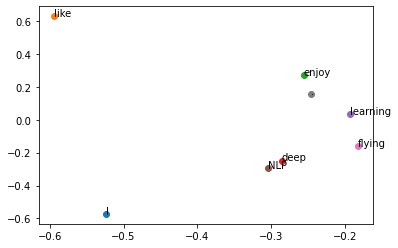

In [5]:
import matplotlib.pyplot as plt

for i in range(len(words)):
    plt.scatter(U[i, 0], U[i, 1])
    plt.text(U[i, 0], U[i, 1], words[i])

plt.show()

# GloVe

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import bz2
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.sparse import lil_matrix
import nltk # standard preprocessing
import operator # sorting items in dictionary by value
#nltk.download() #tokenizers/punkt/PY3/english.pickle
from math import ceil

D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:5

# 1 数据集下载

In [2]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('wikipedia2text-extracted.txt.bz2', 18377035)

Found and verified wikipedia2text-extracted.txt.bz2


# 2 读取数据集

该步骤主要包含：将数据读取出来成为string，将数据全部转换为小写，对数据进行分词操作。每次读取读取1M数据

In [3]:
def read_data(filename):
    """
    Extract the first file enclosed in a zip file as a list of words
    and pre-processes it using the nltk python library
    """

    with bz2.BZ2File(filename) as f:

        data = []
        file_size = os.stat(filename).st_size
        chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
        print('Reading data...')
        for i in range(ceil(file_size//chunk_size)+1):
            bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
            file_string = f.read(bytes_to_read).decode('utf-8')
            file_string = file_string.lower()  # 将数据转换为小写
            # tokenizes a string to words residing in a list
            file_string = nltk.word_tokenize(file_string)  # 分词
            data.extend(file_string)
    return data

words = read_data(filename)
print('Data size %d' % len(words))
token_count = len(words)

print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])

Reading data...
Data size 3361192
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


# 3 创建词典

根据以下的规则进行词典的创建. 为了方便理解以下的元素，采用 "I like to go to school"作为例子.

* `dictionary`: 词语与ID之间的映射关系 (e.g. {'I': 0, 'like': 1, 'to': 2, 'go': 3, 'school': 4})
* `reverse_dictionary`: ID与词语之间的映射关系 (e.g. {0: 'I', 1: 'like', 2: 'to', 3: 'go', 4: 'school'})
* `count`: 列表，列表中每个元素是个元组，每个元组中的元素为单词以及频率 (word, frequency) (e.g. [('I', 1), ('like', 1), ('to', 2), ('go', 1), ('school', 1)])
* `data` : 文本中的词语，这些词语以ID来代替 (e.g. [0, 1, 2, 3, 2, 4])

标记 `UNK` 来表示稀有词语。

词典中只统计50000个常见词。

In [8]:
# we restrict our vocabulary size to 50000
vocabulary_size = 50000 

def build_dataset(words):
    count = [['UNK', -1]]
    # Gets only the vocabulary_size most common words as the vocabulary
    # All the other words will be replaced with UNK token
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()

    # Create an ID for each word by giving the current length of the dictionary
    # And adding that item to the dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    # Traverse through all the text we have and produce a list
    # where each element corresponds to the ID of the word found at that index
    for word in words:
        # If word is in the dictionary use the word ID,
        # else use the ID of the special token "UNK"
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    
    # update the count variable with the number of UNK occurences
    count[0][1] = unk_count
  
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    # Make sure the dictionary is of size of the vocabulary
    assert len(dictionary) == vocabulary_size
    
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 68751], ('the', 226893), (',', 184013), ('.', 120919), ('of', 116323)]
Sample data [1721, 9, 8, 16479, 223, 4, 5168, 4459, 26, 11597]


# 4 生成GloVe的batch数据

`batch`是中心词；`labels`是中心词上下文窗口中的词语。对于中心词的上下文，每次读取`2 * window_size + 1`个词语，称之为`span`。每个`span`中，中心词为`1`，上下文大小为`2 * window_size`。该函数以这种方式继续，直到创建`batch_size`数据点。每次到达单词序列的末尾时，我们都会从头开始。

`batch`: $1 \times 8$的向量; `labels`: $8 \times 1$的向量; `weights`: $1 \times 8$的向量，词语$i$与词语$j$共现的次数，$\frac{1}{d}$，其中$d$为两个词之间的距离。

In [42]:
data_index = 0

def generate_batch(batch_size, window_size):
    # data_index is updated by 1 everytime we read a data point
    global data_index 
    
    # two numpy arras to hold target words (batch)
    # and context words (labels)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    weights = np.ndarray(shape=(batch_size), dtype=np.float32)

    # span defines the total window size, where
    # data we consider at an instance looks as follows. 
    # [ skip_window target skip_window ]
    span = 2 * window_size + 1 
    
    # The buffer holds the data contained within the span
    buffer = collections.deque(maxlen=span)
  
    # Fill the buffer and update the data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
  
    # This is the number of context words we sample for a single target word
    num_samples = 2*window_size 

    # We break the batch reading into two for loops
    # The inner for loop fills in the batch and labels with 
    # num_samples data points using data contained withing the span
    # The outper for loop repeat this for batch_size//num_samples times
    # to produce a full batch
    for i in range(batch_size // num_samples):
        k=0
        # avoid the target word itself as a prediction
        # fill in batch and label numpy arrays
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            # 因为 j 是跳过了 window_size 的，所以 j - window_size 不会为0
            weights[i * num_samples + k] = abs(1.0/(j - window_size))
            k += 1 
    
        # Everytime we read num_samples data points,
        # we have created the maximum number of datapoints possible
        # withing a single span, so we need to move the span by 1
        # to create a fresh new span
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels, weights

print('data:', [reverse_dictionary[di] for di in data[:9]])

for window_size in [2, 4]:
    data_index = 0
    batch, labels, weights = generate_batch(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    weights:', [w for w in weights])
    
    # print(batch)
    # print(labels)

data: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

with window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']
    weights: [0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.5]

with window_size = 4:
    batch: ['set', 'set', 'set', 'set', 'set', 'set', 'set', 'set']
    labels: ['propaganda', 'is', 'a', 'concerted', 'of', 'messages', 'aimed', 'at']
    weights: [0.25, 0.33333334, 0.5, 1.0, 1.0, 0.5, 0.33333334, 0.25]


# 5 生成共现概率矩阵

`lil_matrix(arg1, shape=None, dtype=None, copy=False)`, 基于行连接存储的稀疏矩阵。lil_matrix使用两个列表保存非零元素。data保存每行中的非零元素，rows保存非零元素所在的列。这种格式也很适合逐个添加元素，并且能快速获取行相关的数据。

In [14]:
# We are creating the co-occurance matrix as a compressed sparse colum matrix from scipy. 
cooc_data_index = 0
dataset_size = len(data) # We iterate through the full text
skip_window = 4 # How many words to consider left and right.

# The sparse matrix that stores the word co-occurences
cooc_mat = lil_matrix((vocabulary_size, vocabulary_size), dtype=np.float32)

print(cooc_mat.shape)
def generate_cooc(batch_size, skip_window):
    '''
    Generate co-occurence matrix by processing batches of data
    '''
    data_index = 0
    print('Running %d iterations to compute the co-occurance matrix'%(dataset_size//batch_size))
    for i in range(dataset_size//batch_size):
        # Printing progress
        if i>0 and i%100000==0:
            print('\tFinished %d iterations'%i)
            
        # Generating a single batch of data
        batch, labels, weights = generate_batch(batch_size, skip_window)
        labels = labels.reshape(-1)
        
        # Incrementing the sparse matrix entries accordingly
        # inp: 中心词 i 的 id
        # lbl: 上下文词语 j 的 id
        # w: i 与 j 共现的频率
        for inp,lbl,w in zip(batch,labels,weights):            
            cooc_mat[inp,lbl] += (1.0*w)

# Generate the matrix
generate_cooc(8,skip_window)    

# Just printing some parts of co-occurance matrix
print('Sample chunks of co-occurance matrix')


# Basically calculates the highest cooccurance of several chosen word
for i in range(10):
    idx_target = i
    
    # get the ith row of the sparse matrix and make it dense
    ith_row = cooc_mat.getrow(idx_target)     
    ith_row_dense = ith_row.toarray('C').reshape(-1)  # 获得频率，如果ith_row没有这个元素，那么就是0     
    
    # select target words only with a reasonable words around it.
    # 获得一个 X_i 在 10 - 50000 之间的单词
    while np.sum(ith_row_dense)<10 or np.sum(ith_row_dense)>50000:
        # Choose a random word
        idx_target = np.random.randint(0,vocabulary_size)
        
        # get the ith row of the sparse matrix and make it dense
        ith_row = cooc_mat.getrow(idx_target) 
        ith_row_dense = ith_row.toarray('C').reshape(-1)    
        
    print('\nTarget Word: "%s"'%reverse_dictionary[idx_target])
        
    # sort_indices 按照从小到大排序 ith_row_dense (词频从小到大排序), 结果为索引
    sort_indices = np.argsort(ith_row_dense).reshape(-1) # indices with highest count of ith_row_dense
    # 按照从大到小排序 ith_row_dense (词频从大到小排序), 结果为索引
    sort_indices = np.flip(sort_indices,axis=0) # reverse the array (to get max values to the start)

    # printing several context words to make sure cooc_mat is correct
    print('Context word:',end='')
    for j in range(10):        
        idx_context = sort_indices[j]       
        print('"%s"(id:%d,count:%.2f), '%(reverse_dictionary[idx_context],idx_context,ith_row_dense[idx_context]),end='')
    print()

(50000, 50000)
Running 420149 iterations to compute the co-occurance matrix
	Finished 100000 iterations
	Finished 200000 iterations
	Finished 300000 iterations
	Finished 400000 iterations
Sample chunks of co-occurance matrix

Target Word: "UNK"
Context word:","(id:2,count:3247.72), "UNK"(id:0,count:2071.51), "the"(id:1,count:1967.02), "and"(id:5,count:1425.50), "."(id:3,count:1304.42), "of"(id:4,count:1048.25), "("(id:13,count:1008.75), "in"(id:6,count:802.75), ")"(id:12,count:770.92), "a"(id:8,count:583.83), 

Target Word: "engaging"
Context word:"in"(id:6,count:2.00), ","(id:2,count:1.25), "from"(id:21,count:1.00), "every"(id:326,count:1.00), "remained"(id:471,count:1.00), "with"(id:17,count:1.00), "women"(id:445,count:1.00), "the"(id:1,count:0.92), "chickens"(id:12727,count:0.50), "traditionally"(id:1854,count:0.50), 

Target Word: "arguably"
Context word:"the"(id:1,count:1.50), ","(id:2,count:1.50), "as"(id:10,count:1.33), "."(id:3,count:1.33), "is"(id:9,count:1.00), "can"(id:57,co

# 6 GloVe 算法

## 6.1 定义超参数

`batch_size`: 每个 batch 中的样本数；`embedding_size`: 嵌入层向量的大小；`window_size`: 上下文窗口大小；`valid_examples`: 随机选择的验证集样本（随机选择后就是常量了）； `epsilon`: 防止 ${\rm log}$ 发散。

In [34]:
batch_size = 128 # Data points in a single batch
embedding_size = 128 # Dimension of the embedding vector.
window_size = 4 # How many words to consider left and right.

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

num_sampled = 32 # Number of negative examples to sample.

epsilon = 1 # used for the stability of log in the loss function

## 6.2 定义输入与输出

为每一个`batch_size`的内容创建训练集中输入与输出的`placeholders`，并且为验证集创建一个常数的tensor。

In [32]:
tf.reset_default_graph()

# Training input data (target word IDs).
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# Training input label data (context word IDs)
train_labels = tf.placeholder(tf.int32, shape=[batch_size])
# Validation input data, we don't need a placeholder
# as we have already defined the IDs of the words selected
# as validation data
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## 6.3 定义模型参数以及其他变量

`in_embeddings`: $W$, $50000 \times 128$; `in_bias_embeddings`: $b$, $50000 \times 1$; `out_embeddings`: $\tilde{W}$, $50000 \times 128$; `out_bias_embeddings`: $\tilde{b}$, $50000$

词向量初始化都是$[-1, 1]$的均匀分布，偏置初始化都是$[0, 0.01]$的均匀分布

In [33]:
# Variables.
in_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
in_bias_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

out_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),name='embeddings')
out_bias_embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size],0.0,0.01,dtype=tf.float32),name='embeddings_bias')

## 6.4 定义模型计算

定义了4个查找方法：`embed_in`, `embed_out`, `embed_bias_in`, `embed_bias_out`。

`weights_x`: $1 \times 8$, 权重函数 $f(X_{ij})$

`x_ij`: $1 \times 8$, 词语 $i$ 与 $j$ 的共现频率, $X_{ij}$

损失函数：$J=\sum_{i, j=1}^V f(X_{ij}) (w_i^T \tilde{w}_j + b_i + \tilde{b}_j - {\rm log}(1 + X_{ij}))^2$

In [35]:
# Look up embeddings for inputs and outputs
# Have two seperate embedding vector spaces for inputs and outputs
embed_in = tf.nn.embedding_lookup(in_embeddings, train_dataset)
embed_out = tf.nn.embedding_lookup(out_embeddings, train_labels)
embed_bias_in = tf.nn.embedding_lookup(in_bias_embeddings,train_dataset)
embed_bias_out = tf.nn.embedding_lookup(out_bias_embeddings,train_labels)

# weights used in the cost function
weights_x = tf.placeholder(tf.float32,shape=[batch_size],name='weights_x') 
# Cooccurence value for that position
x_ij = tf.placeholder(tf.float32,shape=[batch_size],name='x_ij')

# Compute the loss defined in the paper. Note that 
# I'm not following the exact equation given (which is computing a pair of words at a time)
# I'm calculating the loss for a batch at one time, but the calculations are identical.
# I also made an assumption about the bias, that it is a smaller type of embedding
loss = tf.reduce_mean(
    weights_x * (tf.reduce_sum(embed_in*embed_out,axis=1) + embed_bias_in + embed_bias_out - tf.log(epsilon+x_ij))**2)


## 6.5 相似度计算

采用余弦相似度计算词语的相似度

In [38]:
# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
embeddings = (in_embeddings + out_embeddings)/2.0  # X = U + V
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))  # 矩阵中每行元素的模
normalized_embeddings = embeddings / norm  # L2正则化
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)  # 提取验证集中的数据
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))  # 余弦相似度

## 6.6 定义模型参数优化器

采用Adagrad优化器

In [36]:
# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## 6.7 运行GloVe模型

训练数据，训练`num_steps`次。并且在每次迭代中，在一个固定的验证集中评估算法，并且打印出距离给定词语最近的词语。

从结果来看，随着训练的进行，最接近验证集中词语的词语是一直在发生改变的

In [39]:
num_steps = 100001
glove_loss = []

average_loss = 0
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    
    tf.global_variables_initializer().run()
    print('Initialized')
    
    for step in range(num_steps):
        
        # generate a single batch (data,labels,co-occurance weights)
        batch_data, batch_labels, batch_weights = generate_batch(
            batch_size, skip_window) 
        
        # 因为已经计算出来了共现矩阵，所以这里不需要 batch_weights
        # Computing the weights required by the loss function
        batch_weights = [] # weighting used in the loss function
        batch_xij = [] # weighted frequency of finding i near j
        
        # Compute the weights for each datapoint in the batch
        for inp,lbl in zip(batch_data,batch_labels.reshape(-1)):  
            # 100: x_max, 0.75: 3/4, point_weight: f(X_ij), batch_xij: 词语 i 与 j 的频率
            point_weight = (cooc_mat[inp,lbl]/100.0)**0.75 if cooc_mat[inp,lbl]<100.0 else 1.0 
            batch_weights.append(point_weight)
            batch_xij.append(cooc_mat[inp,lbl])
        batch_weights = np.clip(batch_weights,-100,1)
        batch_xij = np.asarray(batch_xij)
        
        # Populate the feed_dict and run the optimizer (minimize loss)
        # and compute the loss. Specifically we provide
        # train_dataset/train_labels: training inputs and training labels
        # weights_x: measures the importance of a data point with respect to how much those two words co-occur
        # x_ij: co-occurence matrix value for the row and column denoted by the words in a datapoint
        feed_dict = {train_dataset : batch_data.reshape(-1), train_labels : batch_labels.reshape(-1),
                     weights_x:batch_weights,x_ij:batch_xij}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # Update the average loss variable
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            glove_loss.append(average_loss)
            average_loss = 0
        
        # Here we compute the top_k closest words for a given validation word
        # in terms of the cosine distance
        # We do this for all the words in the validation set
        # Note: This is an expensive step
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
            
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step 0: 8.672687
Nearest to ,: pitcher, discharges, pigs, tolerant, fuzzy, medium-, on-campus, eduskunta,
Nearest to this: mediastinal, destined, implementing, honolulu, non-mormon, juniors, tycho, powered,
Nearest to most: translating, absolute, 111, bechet, adam, aleksey, penetrators, rake,
Nearest to but: motown, ridged, beginnings, shareholder, resurfacing, english, intelligence, o'dea,
Nearest to is: higher-quality, kitchener, kelley, confronted, m15, stanislaus, depictions, buf,
Nearest to ): encyclopedic, commute, symbiotic, forecasts, 1993., 243-year, cenwealh, inclosure,
Nearest to not: toulon, discount, dunblane, vividly, recorded, olive, afrikaansche, german-speaking,
Nearest to with: tofu, expansive, penned, grids, 102, drought, merced, cunningham,
Nearest to ;: all-electric, internationally-recognised, czars, 12–16, kana, immaculate, innings, wnba,
Nearest to a: non-residents, presumption, cephas, tau, stepfather, beside, aorist, vom,
Nearest to